<a href="https://colab.research.google.com/github/shivtejshete/Computer-Vision/blob/master/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import os

In [2]:
print(tf.__version__)
print(keras.__version__)


2.3.0
2.4.3


In [3]:
#building the datapipeline 
url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

zip_path = tf.keras.utils.get_file('cats_dogs.zip', origin=url, extract=True)

path = os.path.join(os.path.dirname(zip_path), 'cats_and_dogs_filtered' )

train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')

batch_size = 32
image_size = (160, 160)


68608000/68606236 [==============================] - 2s 0us/step


In [4]:
train_dataset = keras.preprocessing.image_dataset_from_directory(train_dir, batch_size=batch_size, image_size=image_size, shuffle=True, color_mode='rgb')

Found 2000 files belonging to 2 classes.


In [7]:
class_indices = train_dataset.class_names
print(class_indices)

['cats', 'dogs']


In [8]:
validation_dataset = keras.preprocessing.image_dataset_from_directory(validation_dir, batch_size = batch_size, image_size = image_size, shuffle=True, color_mode='rgb')

Found 1000 files belonging to 2 classes.


1
1
0
0


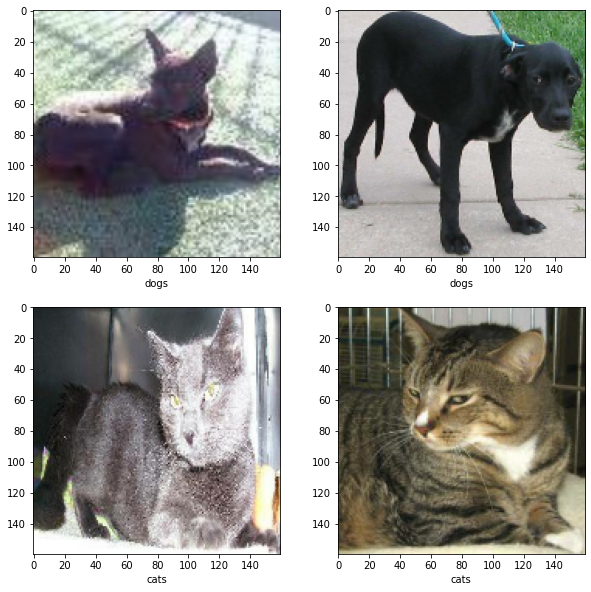

In [9]:
#plotting sample data from first batch of training dataset
plt.figure(figsize = (10,10))
for image, label in train_dataset.take(1):
  for i in range(4):
      ax= plt.subplot(2,2,i+1)
      plt.imshow(np.array(image[i], dtype= 'int'))
      plt.xlabel(class_indices[label[i]])
      tf.print(label[i])


In [10]:
#checking number of batches into validation dataset
value_batches = tf.data.experimental.cardinality(validation_dataset)

In [11]:
#creation of test data subset
test_dataset=validation_dataset.take(value_batches//5)
validation_dataset= validation_dataset.skip(value_batches//5)

In [12]:
#checking number of batches into training dataset
tf.print(tf.data.experimental.cardinality(train_dataset))

63


In [13]:
#he number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step.
#  You could either manually tune this value, or set it 
# to tf.data.experimental.AUTOTUNE which will prompt the tf.data runtime to tune the value dynamically at runtime.
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [14]:

#Prefetch the data for reducing latency and increase throughput 
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [15]:
#Augmentation layer, its no required if we use a generator from keras
augment = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomRotation(0.2, seed=11),
    keras.layers.experimental.preprocessing.RandomFlip( seed=1),
    keras.layers.experimental.preprocessing.RandomContrast(factor = 0.1)
]
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


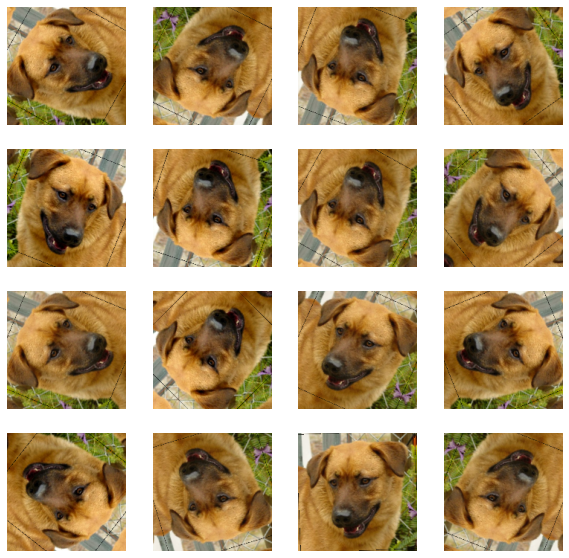

In [16]:
#visualize how data augmentation happens
for image, label in train_dataset.take(1):
  plt.figure(figsize=(10,10))
  image2 = image[1]
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    augmented = augment(np.expand_dims(image2, 0))
    plt.imshow(np.reshape(np.array(augmented, dtype = 'int'),(160,160,3)))
    plt.axis(False )

In [17]:
#MobileNetV2 has some preprocessing and we can access that specific layer directly to process our data in same fashion
#This is just a rescale of data by 255.0
preprocess_data_for_imagenetv2 = tf.keras.applications.mobilenet_v2.preprocess_input




In [18]:
# Building block of Image netv2 = [Expansion layer, batch Normalization, ReLU] + [Conv+BN+ReLU] + [Projection Layer+ BN] + Residual from begininng 
# The full MobileNet V2 architecture consists of 17 of these building blocks in a row. 
# This is followed by a regular 1×1 convolution, a global average pooling layer, and a classification layer.
image_shape = image_size + (3,)

base_model = keras.applications.MobileNetV2( input_shape= image_shape , include_top=False, weights= 'imagenet')

9412608/9406464 [==============================] - 1s 0us/step


In [19]:
#Model takes in 160 with 3 channel image size and converts it into 5 with 1280 channels
# 
base_model.summary()


Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [20]:
#total number of layers in the architecture 
len(base_model.layers)

155

In [21]:
# Seeing if architecture giving expected outcome for input batches 
for image, _ in train_dataset.take(1):
  feature_output = base_model(image)
  print(feature_output.shape)

(32, 5, 5, 1280)


In [22]:
#Freeze all the layers of chosen architecture to avoid retraining
base_model.trainable = False

In [23]:
#Checking the effect of setting trainable to false
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [24]:
# Adding a top layer of classifier to identify dogs and cats  

#Averaging the values of features per image into 1280 element vector, we can use flatten as well
average_pool = keras.layers.GlobalAveragePooling2D( )

#Checking the average pooling on a single image
for image, _ in train_dataset.take(1):
  features= base_model(np.expand_dims(image[0], 0))
  print('Model output shape :',features.shape)
  averaged = average_pool(features)
  print('Shape After average pooling layer :',averaged.shape)

Model output shape : (1, 5, 5, 1280)
Shape After average pooling layer : (1, 1280)


In [25]:
#Prediction layer which is a classifier top layer, we dont need to specify activation function, could also sigmoid be used
prediction_layer = keras.layers.Dense( units =1 )

In [26]:
#Checking prediction on a single image average pool
prediction_layer(averaged) 

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.14600444]], dtype=float32)>

In [27]:
#groups layers into an object with training and inference features

input = keras.layers.Input( shape = image_shape )
x= augment(input)
x= preprocess_data_for_imagenetv2(x)
x= base_model( x, training = False)
x= average_pool(x)

x = keras.layers.Dropout( 0.2 , seed = 111)(x)

output = prediction_layer(x)

model = keras.Model( inputs = input, outputs = output )


In [28]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

In [29]:
model.trainable_variables

[<tf.Variable 'dense/kernel:0' shape=(1280, 1) dtype=float32, numpy=
 array([[ 0.06286053],
        [-0.00135942],
        [ 0.06647113],
        ...,
        [ 0.03915417],
        [ 0.05211286],
        [-0.0213765 ]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

In [30]:
learning_rate = 0.001
model.compile( optimizer = tf.keras.optimizers.Adam(learning_rate= learning_rate), 
              loss = tf.keras.losses.BinaryCrossentropy( from_logits= True),
              metrics = ['accuracy'])

In [31]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

In [34]:

#Checking accuracy of starting
initial_epoch = 8

loss1, accuracy1 = model.evaluate(validation_dataset)


26/26 [==============================] - 2s 58ms/step - loss: 0.6360 - accuracy: 0.6770


In [35]:
initial_epoch = 8

In [36]:
history = model.fit(train_dataset,
                    epochs=initial_epoch,
                    validation_data=validation_dataset)

Epoch 1/8
63/63 [==============================] - 7s 107ms/step - loss: 0.3877 - accuracy: 0.8015 - val_loss: 0.1424 - val_accuracy: 0.9579
Epoch 2/8
63/63 [==============================] - 6s 103ms/step - loss: 0.2597 - accuracy: 0.8850 - val_loss: 0.1048 - val_accuracy: 0.9691
Epoch 3/8
63/63 [==============================] - 6s 103ms/step - loss: 0.2307 - accuracy: 0.8935 - val_loss: 0.0978 - val_accuracy: 0.9691
Epoch 4/8
63/63 [==============================] - 6s 103ms/step - loss: 0.2225 - accuracy: 0.9075 - val_loss: 0.0834 - val_accuracy: 0.9715
Epoch 5/8
63/63 [==============================] - 6s 103ms/step - loss: 0.2120 - accuracy: 0.9070 - val_loss: 0.0782 - val_accuracy: 0.9752
Epoch 6/8
63/63 [==============================] - 7s 104ms/step - loss: 0.1985 - accuracy: 0.9120 - val_loss: 0.0807 - val_accuracy: 0.9728
Epoch 7/8
63/63 [==============================] - 7s 104ms/step - loss: 0.1908 - accuracy: 0.9130 - val_loss: 0.0742 - val_accuracy: 0.9765
Epoch 8/8
63/

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

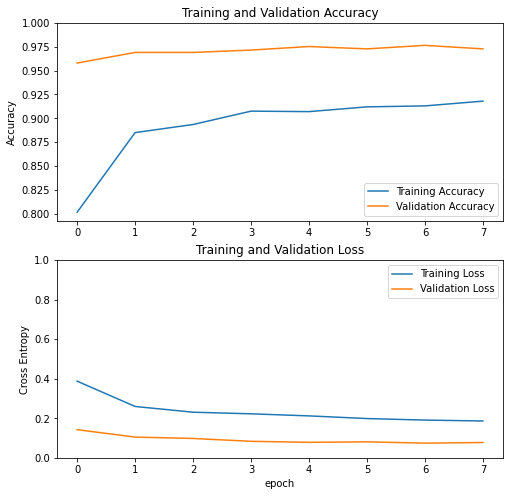

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Test with an image

In [69]:
#Outside Test single sample for model
link = 'https://www.guidedogs.org.au/wp-content/uploads/2020/05/Guide-Dog-partnership-1-710x623.jpg'
path_cat = keras.utils.get_file('cat1', origin=link )
path_cat
cat_pil_image = keras.preprocessing.image.load_img(path_cat, color_mode='rgb', target_size=image_size)
sample_cat = keras.preprocessing.image.img_to_array(cat_pil_image)

model.predict(np.expand_dims(sample_cat, 0))

65536/62307 [===============================] - 1s 13us/step


array([[6.593729]], dtype=float32)

Fine Tune the model

In [73]:
#Fine tuning involves updating weights of some of the layers of ConNet to be retrained on underlining dataset to learn complex specific features 
#unfreezing the base model 
base_model.trainable = True

#checking number of layers in Base model
len(base_model.layers)

#Freezing bottom 100 layers from training on given dataset
start_training_at= 100
for layer in base_model.layers[:start_training_at]:
   layer.trainable= False

In [80]:
#recompile the model with changed optimizer and changed learning rate (lowered)
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate/10.0),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics = ['accuracy'] )

In [81]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

In [84]:
#different 
len(model.trainable_variables)

58

In [87]:
#additional fine tuning epochs 
fine_tune_epochs = 10
total_epochs = initial_epoch + fine_tune_epochs
history_fine  = model.fit( train_dataset, validation_data= validation_dataset ,epochs=total_epochs, initial_epoch=  history.epoch[-1] )

Epoch 8/18
63/63 [==============================] - 9s 138ms/step - loss: 0.5943 - accuracy: 0.7725 - val_loss: 0.1409 - val_accuracy: 0.9740
Epoch 9/18
63/63 [==============================] - 8s 121ms/step - loss: 0.2870 - accuracy: 0.8745 - val_loss: 0.1558 - val_accuracy: 0.9653
Epoch 10/18
63/63 [==============================] - 8s 122ms/step - loss: 0.2500 - accuracy: 0.8900 - val_loss: 0.0882 - val_accuracy: 0.9678
Epoch 11/18
63/63 [==============================] - 8s 122ms/step - loss: 0.1966 - accuracy: 0.9155 - val_loss: 0.3357 - val_accuracy: 0.9010
Epoch 12/18
63/63 [==============================] - 8s 123ms/step - loss: 0.1948 - accuracy: 0.9230 - val_loss: 0.0688 - val_accuracy: 0.9715
Epoch 13/18
63/63 [==============================] - 8s 123ms/step - loss: 0.1791 - accuracy: 0.9290 - val_loss: 0.0764 - val_accuracy: 0.9715
Epoch 14/18
63/63 [==============================] - 8s 123ms/step - loss: 0.1705 - accuracy: 0.9355 - val_loss: 0.0610 - val_accuracy: 0.9765
E

In [88]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

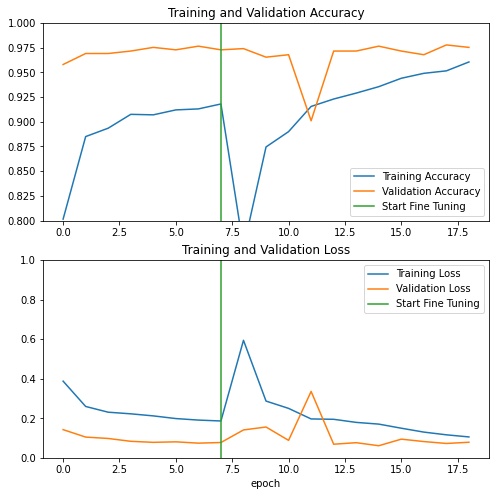

In [90]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epoch-1,initial_epoch-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epoch-1,initial_epoch-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()